In [130]:
import numpy as np
import matplotlib.pyplot as mp
import xarray as xr
import datetime as dt
import cartopy.crs as ccrs
import pandas as pd


<hr>
Initial Simulations Information
<hr>

In [143]:
case_desc = np.array(['C6','C5','rC5now','rUW','rUWp','rMG1','rC5p','rC5pm','rZMc','rZMp','rpfrac','rCE2i']) ; pref_out = 'revert'
#case_desc = np.array(['C6','C5','C4','CE2','CE1','CC4','CE2sst']) ; pref_out = 'release'
#case_desc = np.array(['C6','C5','C4','W110','W121']) ; pref_out = 'waccm_hvr'
#case_desc = np.array(['C6','C5','C4']) ; pref_out = 'cam456'
#case_desc = np.array(['C6','CE2','CE2sst','CE2sstd','REYsstd']) ; pref_out = 'day_mon_Rey_sst_'   
#case_desc = np.array(['C6']) ; pref_out = 'test_'   
    
month_ave = np.array(["Jul","Aug","Sep","Oct","Nov"]) 
#month_ave = np.array(["Jan","Feb","Dec"])
dir_root = '/glade/p/cgd/amp/people/hannay/amwg/climo/'
dir_obs = '/glade/p/cesm/amwg/amwg_data/obs_data/'

#reg_a = [-10,10,120.,160] # lats, lons averaging region - m. Continent
reg_a = [7.5,10,220.,240] # lats, lons averaging region. - E. Pac 1
#reg_a = [5,12,270,280] # lats, lons averaging region. - E. Pac 2
#reg_a = [5,12,240,270] # lats, lons averaging region. - E. Pac 2

#var_names = ['OMEGA','DIV'] ; vscales = [1.,1] ; f1xmin=-0.14; f1xmax=0.02 ;f1dx = 0.02 ; f2xmin=-0.001; f2xmax=0.001 ;f2dx = 0.0004  ; f1name = '[Vertical Velocity [pa/s]]' ; f2name = '[Convergence [/s]]'
var_names = ['ZMDQ','ZMDT'] ; vscales = [86400*1000,86400.] ; f1xmin=-5.; f1xmax=5. ;f1dx = 1. ; f2xmin=-8.; f2xmax=8. ;f2dx = 2.  ; f1name = '[Deep Convection Moistening [g/kg/day]]' ; f2name = '[Deep Convection Heating [K/day]]'
lobs = False

p_levs = np.arange(100.,1050.,50.)


######
sim_names = cam_revert_list()

reg_a_join = ' '.join(str(reg_a))

reg_a_str = '%d-%d\u00b0W %.1f-%d\u00b0N' % (360-reg_a[2],360-reg_a[3],reg_a[0],reg_a[1])
reg_a_out = '%d-%dW_%.1f-%dN' % (360-reg_a[2],360-reg_a[3],reg_a[0],reg_a[1])


<hr>
Main Code
<hr>

5
-Averaging for months -  ['Jul' 'Aug' 'Sep' 'Oct' 'Nov']
-Averaging for region -  140-120°W 7.5-10°N


- Case #  0  of  12
- Name =  C6  -> f.e20.FHIST.f09_f09.cesm2_1.001
['/glade/p/cgd/amp/people/hannay/amwg/climo/f.e20.FHIST.f09_f09.cesm2_1.001/0.9x1.25/f.e20.FHIST.f09_f09.cesm2_1.001_07_climo.nc', '/glade/p/cgd/amp/people/hannay/amwg/climo/f.e20.FHIST.f09_f09.cesm2_1.001/0.9x1.25/f.e20.FHIST.f09_f09.cesm2_1.001_08_climo.nc', '/glade/p/cgd/amp/people/hannay/amwg/climo/f.e20.FHIST.f09_f09.cesm2_1.001/0.9x1.25/f.e20.FHIST.f09_f09.cesm2_1.001_09_climo.nc', '/glade/p/cgd/amp/people/hannay/amwg/climo/f.e20.FHIST.f09_f09.cesm2_1.001/0.9x1.25/f.e20.FHIST.f09_f09.cesm2_1.001_10_climo.nc', '/glade/p/cgd/amp/people/hannay/amwg/climo/f.e20.FHIST.f09_f09.cesm2_1.001/0.9x1.25/f.e20.FHIST.f09_f09.cesm2_1.001_11_climo.nc']

- Case #  1  of  12
- Name =  C5  -> 30L_cam5301_FAMIP.001
['/glade/p/cgd/amp/people/hannay/amwg/climo/30L_cam5301_FAMIP.001/0.9x1.25/30L_cam5301_FAMIP.001_07_climo.nc', '/gl

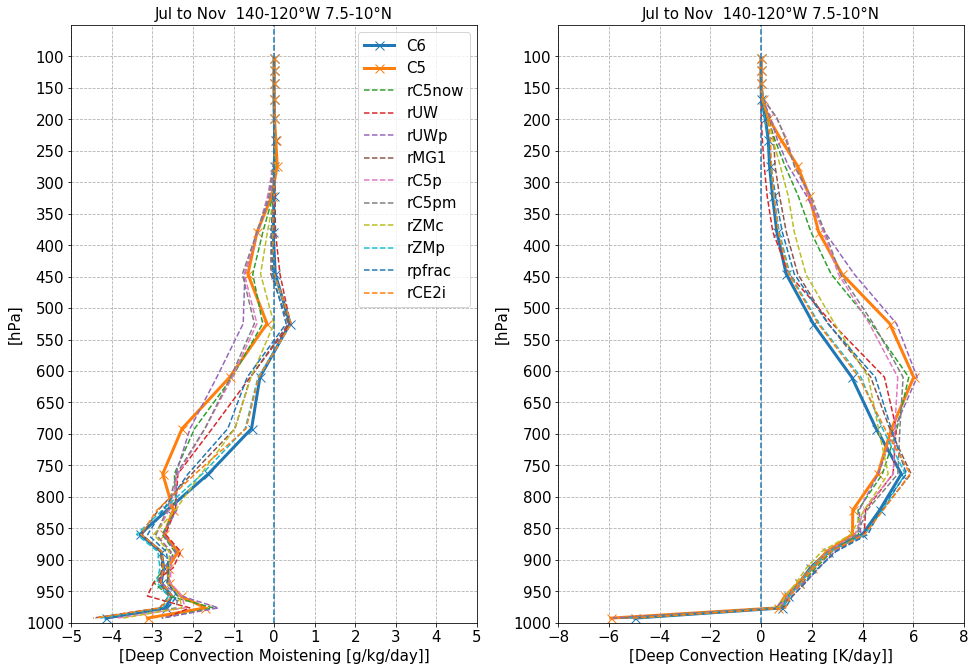

In [144]:
## LOOP ##
fig, ax = mp.subplots(1,2,figsize=(16, 11))

nmnths = month_ave.size
ncases = case_desc.size
print(nmnths)

print('-Averaging for months - ',month_ave)
print('-Averaging for region - ',reg_a_str)
print('')

icase = 0
for ir in case_desc:
        mon_list = []
        case = case_desc[icase]
        sim_name = sim_names.loc[case]['run name']
        
        print('')
        print('- Case # ',icase,' of ',ncases)
        print('- Name = ',case,' ->',sim_name)
        
        mnums = []
        for im in range(0,nmnths): mnums.append(dt.datetime.strptime(month_ave[im], "%b").month) # grab month numbers

        mon_aves = [ "{:02}".format(x) for x in mnums ] # In correct format
        mon_list = ','.join(mon_aves)
        
# Read files in 
        pre_dir = 'yrs_1979-2005' if case=='CE2' else '0.9x1.25'
        files_in = [dir_root+sim_name+'/'+pre_dir+'/'+sim_name+'_'+mon_aves[ff]+'_climo.nc' for ff in range(nmnths)]
        files_ptr = xr.open_mfdataset(files_in)
        print(files_in)
        
# Grab variables for a region (reg_a).
        var_in1 = files_ptr[var_names[0]].loc[:,:,reg_a[0]:reg_a[1],reg_a[2]:reg_a[3]] 
        var_plot1 = vscales[0]*var_in1.mean(dim=['time','lat','lon'])
        
        if var_names[1] != 'DIV':
            var_in2 = files_ptr[var_names[1]].loc[:,:,reg_a[0]:reg_a[1],reg_a[2]:reg_a[3]] 
            var_plot2 = vscales[1]*var_in2.mean(dim=['time','lat','lon'])
        else:
            print(var_plot1)
            var_plot2 = var_plot1.differentiate("lev")

        ps_in = files_ptr['PS'].loc[:,reg_a[0]:reg_a[1],reg_a[2]:reg_a[3]] 
        hyam = files_ptr['hyam'] ; hybm = files_ptr['hybm'] ; P0 = files_ptr['P0'] ; lev = files_ptr['lev']

# Levs
        ilevs = np.where(lev >= min(p_levs))
        ilevs = ilevs[0]
        dp_lev = np.diff(lev)
    
   
# Plots
        if case in ['C4','C5','C6','W110','W121']:
            ax[0].plot(var_plot1[ilevs],lev[ilevs],lw=3,markersize=9,marker='x')   
            ax[1].plot(var_plot2[ilevs],lev[ilevs],lw=3,markersize=9,marker='x')   
#            ax[1].plot(var_plot2[ilevs[0:-1]],lev[ilevs[0:-1]],lw=3,markersize=9,marker='x')   
        else:
            ax[0].plot(var_plot1[ilevs],lev[ilevs],lw=1.5,linestyle='--') 
            ax[1].plot(var_plot2[ilevs],lev[ilevs],lw=1.5,linestyle='--') 
#            ax[1].plot(var_plot2[ilevs[0:-2]],lev[ilevs[0:-2]],lw=1.5,linestyle='--')  
        # End loop here
        icase=icase+1

# Observations

if lobs: 
    obs_name = 'MERRA'
    ofiles_in = [dir_obs+obs_name+'_'+mon_aves[ff]+'_climo.nc' for ff in range(nmnths)]
    print(ofiles_in)
    ofiles_ptr = xr.open_mfdataset(ofiles_in,parallel=True)
    print(var_name)
    ovar_in = ofiles_ptr[var_name].loc[:,:,reg_a[0]:reg_a[1],reg_a[2]:reg_a[3]] 
    print(ovar_in)
    olevs = ofiles_ptr['lev']
    print(olevs)
#    olevs = olev[::-1]
    ilevs = np.where(lev >= min(olevs))
    ilevs = ilevs[0]
#    ilevs = ilevs[::-1]
    print(ilevs)
    print(olevs)
    
    ovar_plotw = ovar_in.mean(dim=['time','lat','lon'])
    ovar_plotw = ovscale*ovar_plotw # Scaling 
    
#    print(ovar_plotw[ilevs].values)
#    ovar_plotd = -np.gradient(ovar_plotw[::-1])
    ax[0].plot(ovar_plotw[ilevs],olevs[ilevs],lw=3,markersize=9,marker='x',color = 'black')   
#    ax[1].plot(ovar_plotd[ilevs],olevs[ilevs],lw=3,markersize=9,marker='x',color = 'black')  
    
mp.rcParams['xtick.labelsize']=15 # GLobal set of xtick label size    
for ifig in [0,1]:
    ax[ifig].invert_yaxis()    
    ax[ifig].set_title(month_ave[0]+' to '+month_ave[nmnths-1]+'  '+reg_a_str,fontsize=15)
    ax[ifig].set_ylabel('[hPa]',fontsize=15) 
    ax[ifig].set_yticks(p_levs)

    ax[ifig].set_yticklabels(p_levs.astype(int),fontsize=15)
    ax[ifig].set_ylim([1000.,50.])
#    ax[ifig].set_yscale("log")
    
    if ifig==0:
        ax[ifig].set_xlabel(f1name,fontsize=15)            
        xlabs = np.arange(f1xmin,f1xmax+f1dx,f1dx)
#        ax[ifig].set_xticks(xlabs)
#        ax[ifig].set_xlim([f1xmin,f1xmax])
    else :
        ax[ifig].set_xlabel(f2name,fontsize=15)     
        xlabs = np.arange(f2xmin,f2xmax+f2dx,f2dx)
#        ax[ifig].set_xticks(xlabs)
 #       ax[ifig].set_xlim([f2xmin,f2xmax])
        
    print(xlabs)
    ax[ifig].set_xticks(xlabs)
#    ax[ifig].set_xticklabels(xlabs,fontsize=15)  

    ax[ifig].axvline(0.,linestyle='--')
    ax[ifig].grid(linestyle='--')  
ax[0].legend(case_desc,fontsize=15)

mp.savefig(pref_out+'_vprof_'+var_names[0]+'_'+var_names[1]+'_'+reg_a_out+'_'+month_ave[0]+'_to_'+month_ave[nmnths-1]+'.png', dpi=150)
#mp.show()




In [145]:
#####################################
# CAM6 Revert Experiments + others   
#####################################


def cam_revert_list():
	

    rl = {} # Revert List
# Releases
    rl['C4']   =  ['f40.1979_amip.track1.1deg.001']
    rl['C5']   =  ['30L_cam5301_FAMIP.001']
    rl['C6']   =  ['f.e20.FHIST.f09_f09.cesm2_1.001']
    rl['CC4']  =  ['b40.20th.track1.1deg.012']
    rl['CE1']  =  ['b.e11.B20TRC5CNBDRD.f09_g16.001']
    rl['CE2']  =  ['b.e21.BHIST.f09_g17.CMIP6-historical.001']

    # Reverts
    rl['rC5now']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5.001']
    rl['rC5']     =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5.001']
    rl['rC5t']    =   ['f.e20.FHIST.f09_f09.cesm2_1_true-cam5_param_topo.001']
    rl['rUWold']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.001']
    rl['rGW']    =   ['f.e20.FHIST.f09_f09.cesm2_1_iogw.001']
    rl['rZMc']  =   ['f.e20.FHIST.f09_f09.cesm2_1_capeten.001']
    rl['rMG1']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.001']
    rl['rSB']  =   ['f.e20.FHIST.f09_f09.cesm2_1_sb.002']
    rl['rTMS']  =   ['f.e20.FHIST.f09_f09.cesm2_1_tms.001']
    rl['rCE2i']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revert125.001']
    rl['rC5p']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.001']
    rl['rC5pm']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertcam5param.002']
    rl['rZMp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cam5_zmconv.001']
    rl['rM3']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mam3.001']
    rl['rUW']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.002']
    rl['rUWp']  =   ['f.e20.FHIST.f09_f09.cesm2_1_uw.003']
    rl['rMG1ii']  =   ['f.e20.FHIST.f09_f09.cesm2_1_mg1.002']
    rl['rice']  =   ['f.e20.FHIST.f09_f09.cesm2_1_ice-micro.001']
    rl['rpfrac']  =   ['f.e20.FHIST.f09_f09.cesm2_1_precip_frac_method.001']
    rl['rpremit']  =   ['f.e20.FHIST.f09_f09.cesm2_1_cld_premit.001']
    rl['rC5psalt']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5seasalt.001']
    rl['rC5pdust']  =   ['f.e20.FHIST.f09_f09.cesm2_1_revertc5dust.001']
    rl['rL30']  =   ['f.e20.FHIST.f09_f09.cesm2_1_L30.001']
    
# SST configs    
    rl['CE2sst']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip.001']
    rl['CE2sstd']  =   ['f.e20.FHIST.f09_f09.cesm2_1_coupled-sst-amip_daily.001']
    rl['REYsstd']  =   ['f.e20.FHIST.f09_f09.cesm2_1_reynolds_daily_sst.006']

    
# High vertical resolution.
    rl['W110']  =   ['f.e21.FWscHIST_BCG.f09_f09_mg17_110L.001']
    rl['W121']  =   ['f.e21.FWscHIST_BCG.f09_f09_mg17_121L_DZ_400m_80kmTop.001']

# Data frame
    rl_df = pd.DataFrame.from_dict(rl, orient='index',columns=['run name'])
    return rl_df
